## MLPP HW1 - Diagnostic

### Importing & Exploring 311 Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib

%matplotlib inline

The Chicago Data Portal has an API, but using their link only gives the 1000 most recent requests. Instead, we can load the data from the file export and then save versions containing only the requests from 2017.

In [2]:
def load(url, date_col='Creation Date', start='12/31/2016', end='01/01/2018'):
    '''
    Loads data from data portal url and returns filtered df with clean col names
    '''
    start = datetime.strptime(start, '%m/%d/%Y')
    end = datetime.strptime(end, '%m/%d/%Y')
    df = pd.read_csv(url)
    # df.columns = map(camelToSnake, df.columns)
    df['date'] = pd.to_datetime(df[date_col], format='%m/%d/%Y')
    df = df[(df['date'] > start) & (df['date'] < end)]
    
    return df

In [49]:
def drop_if(df, col_list=['Ward','ZIP Code','Police District','Community Area'], value=0.0):
    '''
    Remove rows with non meaningful values
    '''
    for col in col_list:
        df = df.drop(df.index[df[col] == value])
        
    return df

In [210]:
def days_between(d1, d2):
    '''
    Compute number of days between request and completion
    '''
    d1 = datetime.strptime(d1, '%m/%d/%Y')
    d2 = datetime.strptime(d2, '%m/%d/%Y')
    return abs((d2 - d1).days)

def compute_response_time(df, col1='Creation Date', col2='Completion Date'):
    '''
    Compute response time for rows in df
    '''
    response_time_list = []
    df = df[~df[col2].isnull()]
    for start, end in zip(list(df[col1]), list(df[col2])):
        if type(start) and type(end) == str:
            days = days_between(end, start)
            response_time_list.append(days)
    df['Response Time (Days)'] = pd.Series(response_time_list, index=df.index)
    return df

def add_month_bins(df, col1='Creation Date'):
    '''
    Adds a numeric bin for the month that a request was created
    '''
    month_list = []
    for day in df[col1]:
        clean = datetime.strptime(day, '%m/%d/%Y')
        month_list.append(clean.month)
    df['Month'] = pd.Series(month_list, index=df.index)
    return df

In [3]:
buildings_url = 'https://data.cityofchicago.org/api/views/7nii-7srd/rows.csv?accessType=DOWNLOAD'
graffiti_url = 'https://data.cityofchicago.org/api/views/hec5-y4x5/rows.csv?accessType=DOWNLOAD'
lights_url = 'https://data.cityofchicago.org/api/views/t28b-ys7j/rows.csv?accessType=DOWNLOAD'

I loaded the files using the function and links above and then pickled the filtered datasets based on date requested, limiting entries to those in 2017. After loading the data, it seems not ideal to combine the three dataframes because the fields in the buildings dataset are just so different from the fields in the graffiti and lights data.

In [4]:
#buildings = load(buildings_url, 'DATE SERVICE REQUEST WAS RECEIVED')
#graffiti = load(graffiti_url)
#lights = load(lights_url)

#buildings.to_pickle('vacant_buildings_17.pkl')
#graffiti.to_pickle('graffiti_17.pkl')
#lights.to_pickle('alley_lights_17.pkl')

In [194]:
buildings = pd.read_pickle('vacant_buildings_17.pkl')
graffiti = pd.read_pickle('graffiti_17.pkl')
lights = pd.read_pickle('alley_lights_17.pkl')

In [195]:
buildings = drop_if(buildings, col_list=['Ward', 'ZIP CODE', 'Police District', 'Community Area'])
graffiti = drop_if(graffiti)
lights = drop_if(lights)

### Number of requests of each type

In [60]:
service_counts = [int(buildings['SERVICE REQUEST TYPE'].value_counts()),
                  int(graffiti['Type of Service Request'].value_counts()),
                  int(lights['Type of Service Request'].value_counts())]
service_types = [list(set(buildings['SERVICE REQUEST TYPE']))[0],
                 list(set(graffiti['Type of Service Request']))[0],
                 list(set(lights['Type of Service Request']))[0]]
for x, y in zip(service_counts, service_types):
    print(y, x)

Vacant/Abandoned Building 3665
Graffiti Removal 112741
Alley Light Out 27887


|Request Type|Number of Requests|
|:--------:|:---:|
|Vacant/Abandoned Buildings| 3665|
|Graffiti Revomal |112741|
|Alley Light Out | 27887|


#### Exploring Graffiti Removal Requests

In [211]:
completed_graffiti = compute_response_time(graffiti)
graffiti_clean = add_month_bins(completed_graffiti)

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [212]:
print(graffiti.shape, graffiti_clean.shape)

(112741, 19) (112735, 21)


In 2017, only 6 graffiti requests were listed as not completed. These requests were likely made at the end of the year. 

In [219]:
def hist_plt(df, col, xlab, vertical=False, sort=True):
    '''
    Function to plot histograms
    '''
    plt.figure(figsize=(16,12))
    if sort:
        hist_idx = df[col].value_counts()
    else:
        hist_idx = df[col].value_counts(sort=False)
    if vertical:
            graph=sns.countplot(y=col, saturation=1, data=df, order=hist_idx.index)
            plt.ylabel(xlab)
            plt.xlabel('Num Requests')
    else:
        graph=sns.countplot(x=col, saturation=1, data=df, order=hist_idx.index)
        plt.xlabel(xlab)
        plt.ylabel('Num Requests')
    plt.title('Histogram Request Counts by '+col)
    plt.show()

#### Number of Requests per Month

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


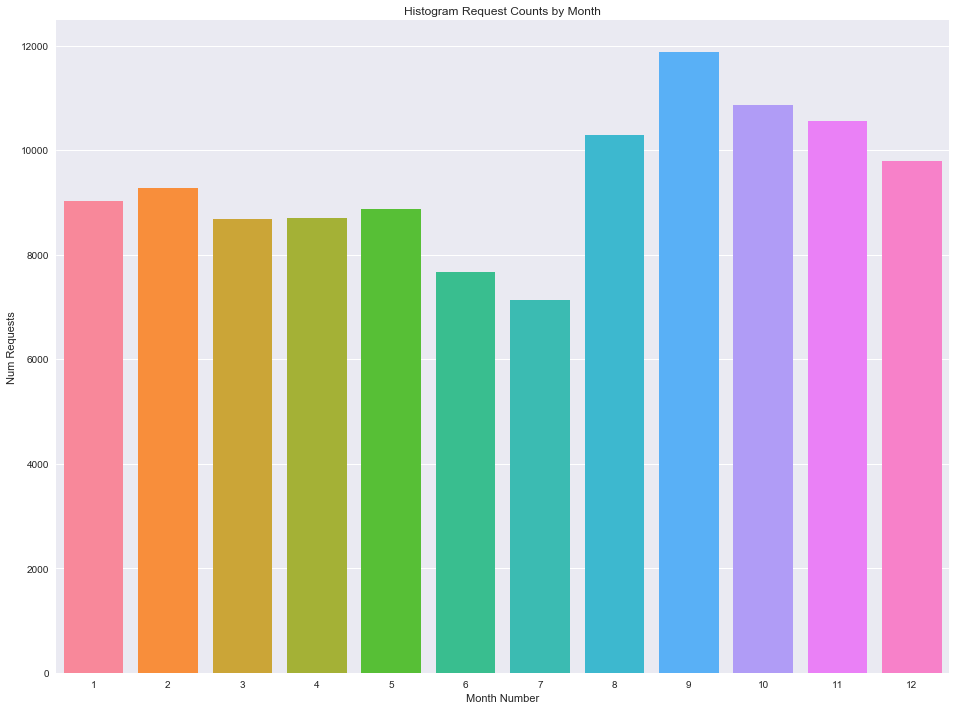

In [221]:
hist_plt(graffiti_clean, 'Month', 'Month Number', vertical=False, sort=False)

#### Number of Requests by Zip Code

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


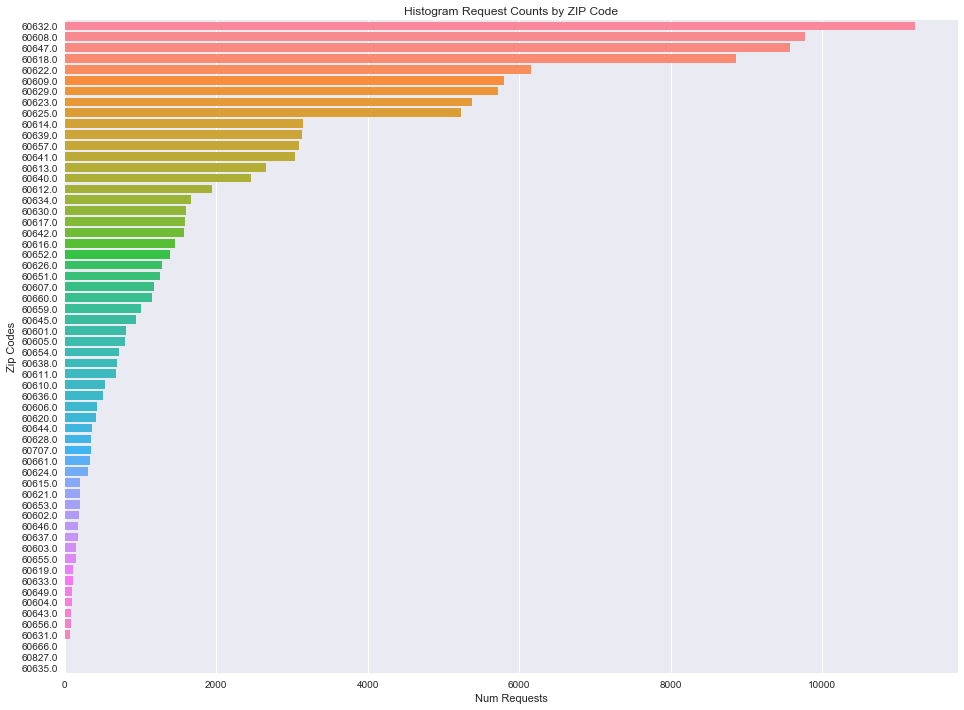

In [222]:
hist_plt(graffiti_clean, 'ZIP Code', 'Zip Codes', vertical=True, sort=True)

#### Requests by Where is the Graffiti Located

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


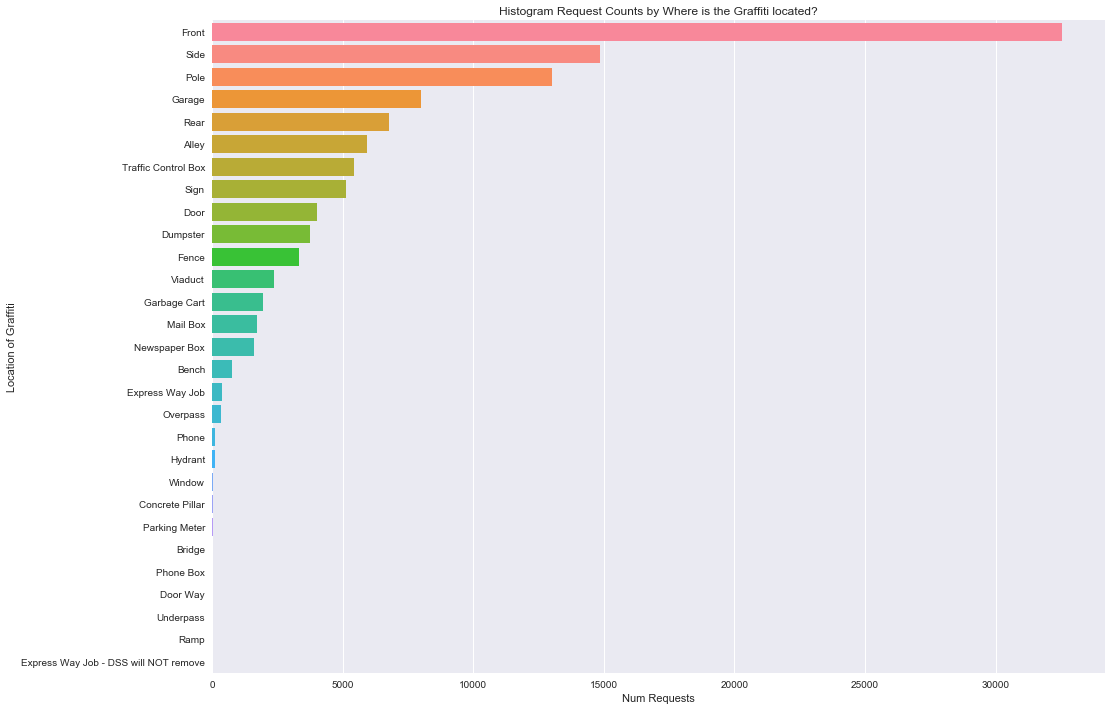

In [224]:
hist_plt(graffiti_clean, 'Where is the Graffiti located?', 'Location of Graffiti', vertical=True, sort=True)

#### Common Locations by Zip Codes

In [218]:
graffiti_clean['Where is the Graffiti located?'].groupby(graffiti_clean['ZIP Code']).value_counts()

ZIP Code  Where is the Graffiti located?
60601.0   Front                             349
          Pole                              121
          Side                               95
          Traffic Control Box                50
          Overpass                           45
          Door                               40
          Fence                              25
          Sign                               22
          Alley                              13
          Dumpster                           10
          Bench                               7
          Newspaper Box                       7
          Concrete Pillar                     6
          Express Way Job                     4
          Garbage Cart                        4
          Rear                                3
          Garage                              2
          Viaduct                             2
          Bridge                              1
          Mail Box                            1

#### Requests by Surface Type

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


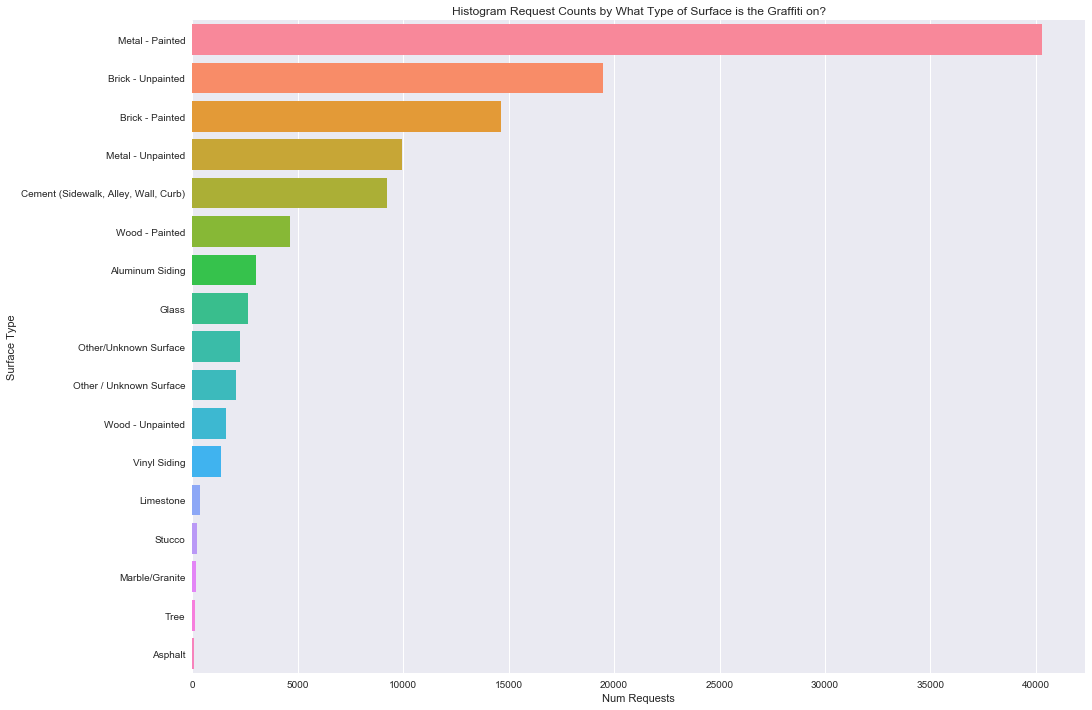

In [225]:
hist_plt(graffiti_clean, 'What Type of Surface is the Graffiti on?', 'Surface Type', vertical=True, sort=True)

#### Common Surfaces by Zip Code

In [217]:
graffiti_clean['What Type of Surface is the Graffiti on?'].groupby(graffiti_clean['ZIP Code']).value_counts()

ZIP Code  What Type of Surface is the Graffiti on?
60601.0   Metal - Painted                             319
          Cement (Sidewalk, Alley, Wall, Curb)        244
          Brick - Unpainted                            63
          Brick - Painted                              51
          Metal - Unpainted                            26
          Glass                                        23
          Wood - Painted                               21
          Limestone                                    18
          Other / Unknown Surface                      18
          Marble/Granite                                7
          Other/Unknown Surface                         7
          Aluminum Siding                               3
          Vinyl Siding                                  3
          Asphalt                                       2
          Wood - Unpainted                              2
60602.0   Metal - Painted                             103
          Brick - Unp

Below we can see the mean response time in days grouped by zip codes as well as the number of requests by zip code. This is obviously difficult to read, so 

In [207]:
completed_graffiti['Response Time (Days)'].groupby(completed_graffiti['ZIP Code']).describe()

,count,mean,std,min,25%,50%,75%,max
ZIP Code,,,,,,,,
60601.0,807.0,0.742255,1.729323,0.0,0.00,0.0,1.00,16.0
60602.0,193.0,0.886010,1.892271,0.0,0.00,1.0,1.00,22.0
60603.0,152.0,0.914474,0.989642,0.0,0.00,1.0,1.00,4.0
60604.0,92.0,0.956522,1.194429,0.0,0.00,1.0,1.00,5.0
60605.0,795.0,0.738365,1.078517,0.0,0.00,0.0,1.00,15.0
60606.0,431.0,0.419954,0.825450,0.0,0.00,0.0,1.00,5.0
60607.0,1183.0,0.555368,1.090694,0.0,0.00,0.0,1.00,16.0
60608.0,9779.0,0.645260,1.109582,0.0,0.00,0.0,1.00,35.0
60609.0,5800.0,0.526207,1.293198,0.0,0.00,0.0,1.00,56.0


In [187]:
graffiti.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,What Type of Surface is the Graffiti on?,Where is the Graffiti located?,Street Address,ZIP Code,X Coordinate,Y Coordinate,Ward,Police District,Community Area,SSA,Latitude,Longitude,Location,date,Response Time (Days)
809105,01/01/2017,Completed,01/04/2017,17-00001597,Graffiti Removal,Glass,Front,4921 N DAMEN AVE,60625.0,1.162119e+06,1.932687e+06,40.0,20.0,4.0,31.0,41.971233,-87.679113,"(41.9712334555571, -87.6791128422349)",2017-01-01,NaN
809435,01/13/2017,Completed,01/17/2017,17-00231928,Graffiti Removal,Glass,Door,3417 W BELMONT AVE,60618.0,1.152969e+06,1.921069e+06,35.0,14.0,21.0,NaN,41.939154,-87.713224,"(41.93915441183761, -87.71322395602864)",2017-01-13,NaN
809723,01/18/2017,Completed,01/18/2017,17-00310369,Graffiti Removal,Glass,Front,1850 W 21ST ST,60608.0,1.164693e+06,1.890111e+06,25.0,12.0,31.0,NaN,41.854161,-87.673019,"(41.85416052575434, -87.67301863276612)",2017-01-18,NaN
809817,01/23/2017,Completed,01/24/2017,17-00414106,Graffiti Removal,Tree,Front,3000 W 38TH PL,60632.0,1.157001e+06,1.878947e+06,12.0,9.0,58.0,NaN,41.823707,-87.699656,"(41.82370686676043, -87.69965619145354)",2017-01-23,NaN
810033,01/23/2017,Completed,01/25/2017,17-00406828,Graffiti Removal,Glass,Sign,717 N RUSH ST,60611.0,1.176971e+06,1.905265e+06,42.0,18.0,8.0,NaN,41.895540,-87.625330,"(41.89553964315842, -87.62533030379964)",2017-01-23,NaN


In [14]:
sum(pd.isnull(graffiti['Completion Date']))

6

In [16]:
sum(pd.isnull(lights["Completion Date"]))

3877

In [47]:
lights.shape

(27895, 16)

In [18]:
buildings.columns

Index(['SERVICE REQUEST TYPE', 'SERVICE REQUEST NUMBER',
       'DATE SERVICE REQUEST WAS RECEIVED',
       'LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD).',
       'IS THE BUILDING DANGEROUS OR HAZARDOUS?',
       'IS BUILDING OPEN OR BOARDED?',
       'IF THE BUILDING IS OPEN, WHERE IS THE ENTRY POINT?',
       'IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?',
       'IS THE BUILDING VACANT DUE TO FIRE?',
       'ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)',
       'ADDRESS STREET NUMBER', 'ADDRESS STREET DIRECTION',
       'ADDRESS STREET NAME', 'ADDRESS STREET SUFFIX', 'ZIP CODE',
       'X COORDINATE', 'Y COORDINATE', 'Ward', 'Police District',
       'Community Area', 'LATITUDE', 'LONGITUDE', 'Location', 'date'],
      dtype='object')

In [130]:
graffiti.columns

Index(['Creation Date', 'Status', 'Completion Date', 'Service Request Number',
       'Type of Service Request', 'What Type of Surface is the Graffiti on?',
       'Where is the Graffiti located?', 'Street Address', 'ZIP Code',
       'X Coordinate', 'Y Coordinate', 'Ward', 'Police District',
       'Community Area', 'SSA', 'Latitude', 'Longitude', 'Location', 'date',
       'Response Time (Days)', 'Months'],
      dtype='object')